# 1. Import Libraries

In [1]:
# data management libraries
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import style
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, make_scorer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import os
import time
import joblib

import random
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product

from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

#always :)
style.use("dark_background") 

In [2]:
# set random seed for reproducibility (np sklearn torch)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 2. Read Data 

In [3]:
df = pd.read_csv('data/transactions.csv')
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [4]:
# check for missing values
df.isnull().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

In [6]:
df.dtypes

step             int64
customer        object
age             object
gender          object
zipcodeOri      object
merchant        object
zipMerchant     object
category        object
amount         float64
fraud            int64
dtype: object

In [5]:
df.describe()

,step,amount,fraud
count,594643.000000,594643.000000,594643.000000
mean,94.986827,37.890135,0.012108
std,51.053632,111.402831,0.109369
min,0.000000,0.000000,0.000000
25%,52.000000,13.740000,0.000000
50%,97.000000,26.900000,0.000000
75%,139.000000,42.540000,0.000000
max,179.000000,8329.960000,1.000000


# 3. EDA

**Features:** 
- **Step:**  
    Represents the day when the transaction happened. There is a total of 180 steps, so the data runs for six months. This field will be **dropped** since its non significant.
- **Customer:**  
    Represents the unique ID of the person who initialized the transaction. It is formed by the letter `C`, followed by a unique sequence of 10 numbers. There is a total of 4,109 unique customers available in the dataset, so this will also be dropped, since the algorithm shouldn't be biased against any customer id.
- **Age:**  
    This variable is split into age intervals, starting from 0 to 6, and the letter `U` which stands for Unknown. Age is Unknown only for transactions that have the gender equal to Enterprise. The coding for the numbers is:  
    - `0`: less than 18 years old  
    - `1`: between 19 and 25 years old  
    - `2`: between 26 and 35 years old  
    - `3`: between 36 and 45 years old  
    - `4`: between 46 and 55 years old  
    - `5`: between 56 and 65 years old  
    - `6`: older than 65 years old  
    - `7`: `U` will be mapped to `7` for numerical encoding purposes. 
- **Gender:**  
    This variable is coded as `F` for Female, `M` for Male, `E` for Enterprise, and `U` for Unknown. The Unknown group has around 170 customers aged in groups 1, 2, and 3. Unkown gender inputs will be dropped, because they are considered as incomplete entries.
- **Merchant:**  
    Represents the unique ID of the party which receives the transaction. Similar to customer ID, the sequence is formed by the letter `M`, followed by a series of 9 numbers. There is a total of 50 unique merchants in the dataset. This column will also be dropped, since the algorithm shouldn't be biased based on merchant id either.
- **Category:**  
    There are 15 unique categories that label the general type of the transaction:  
    `transportation`, `food`, `health`, `wellness and beauty`, `fashion`, `bars and restaurant`, `hyper`, `sports and toys`, `tech`, `home`, `hotel services`, `other services`, `contents`, `travel`, `leisure`.  
- **Amount:**  
    Represents the value of the transaction. There are only 52 values equal to 0 and no negative values.  
- **Fraud:**  
    A flag column coded with `0` if the transaction was clean and with `1` if the transaction was fraudulent.  
- **zipcodeOri** and **zipMerchant:**  
    These two features will be **removed** from the dataset, as they contained a constant value of `28007`, which is a postal code in Ansonville, North Carolina, United States. 

### 3.1. Preprosessing

In [3]:
# drop the columns that are not significant for clustering
df = df.drop(columns=['step', 'customer', 'merchant', 'zipcodeOri', 'zipMerchant'])

#remove 'es_' from the 'category' column
df['category'] = df['category'].str.replace('es_', '', regex=False)

# remove special symbols from all columns
df = df.replace("^.|.$", '', regex=False)

#drop rows that have 'U' in 'gender' column
df = df[df['gender'] != '\'U\'']

# replace 'U' with '7' in age and convert age from str to int
df['age'] = df['age'].replace('\'U\'', '7').str.strip("'\"").astype(int)

# encode the gender/category columns using one-hot encoding keep the original columns
gender = df['gender']
category = df['category']
df = pd.get_dummies(df, columns=['gender', 'category'])
df['gender_original'] = gender
df['category_original'] = category

In [7]:
df.head()

,age,amount,fraud,gender_'E',gender_'F',gender_'M',category_'barsandrestaurants',category_'contents',category_'fashion',category_'food',...,category_'hyper',category_'leisure',category_'otherservices',category_'sportsandtoys',category_'tech',category_'transportation',category_'travel',category_'wellnessandbeauty',gender_original,category_original
0,4,4.55,0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,'M','transportation'
1,2,39.68,0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,'M','transportation'
2,4,26.89,0,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,'F','transportation'
3,3,17.25,0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,'M','transportation'
4,5,35.72,0,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,'M','transportation'


### 3.2. Plotting

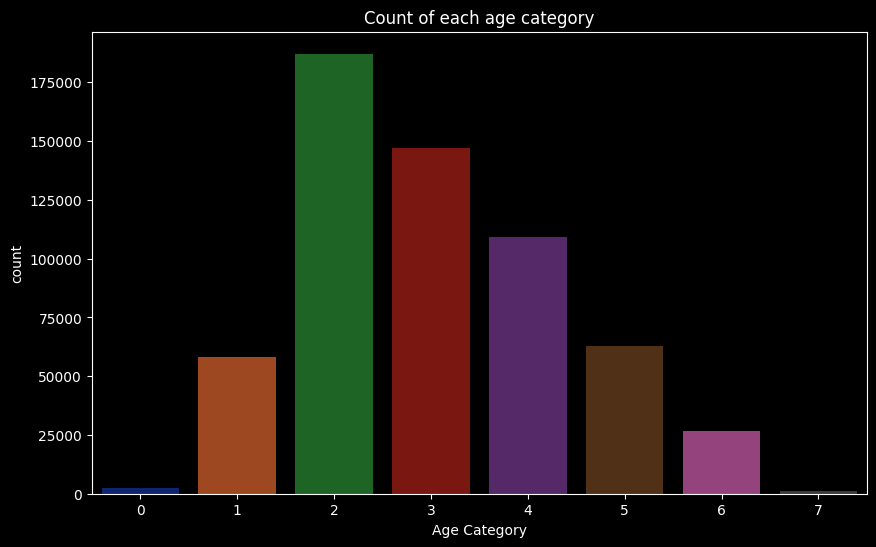

In [12]:
#plot count of each age category
plt.figure(figsize=(10, 6));
sns.countplot(data=df, x='age', hue='age', palette='dark', legend=False);
plt.title('Count of each age category')
plt.xlabel('Age Category')
plt.show()

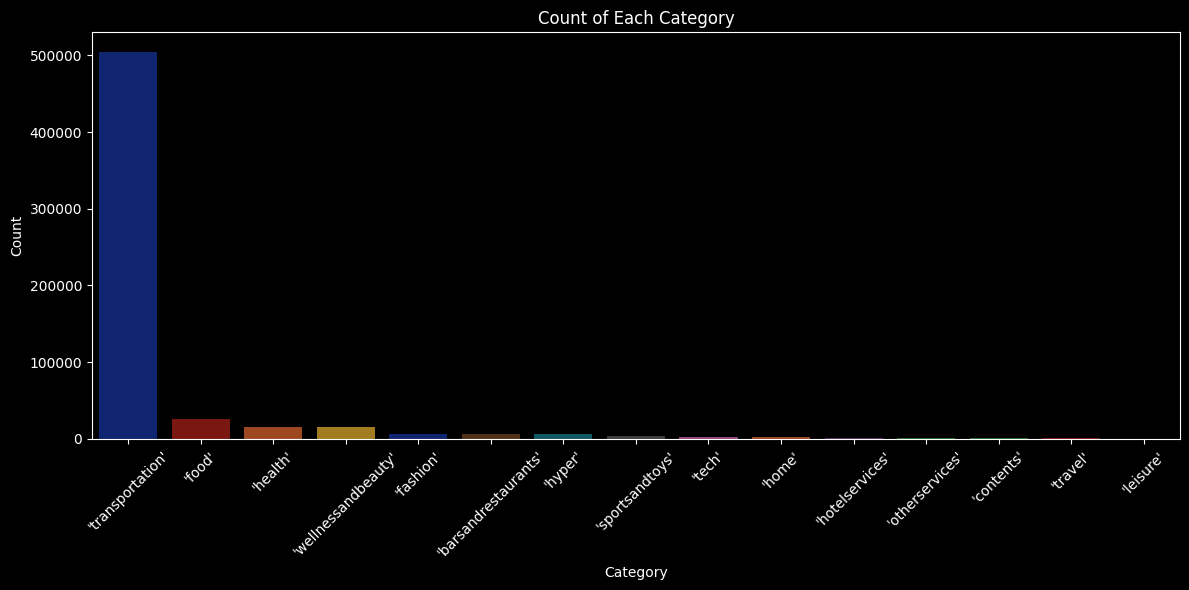

In [13]:
#plot count of each category
plt.figure(figsize=(12, 6))
sns.countplot(data=df, 
    x='category_original', 
    hue='category_original', 
    order=df['category_original'].value_counts().index, 
    palette='dark', 
    dodge=False)
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Count of Each Category')
plt.tight_layout()
plt.show()

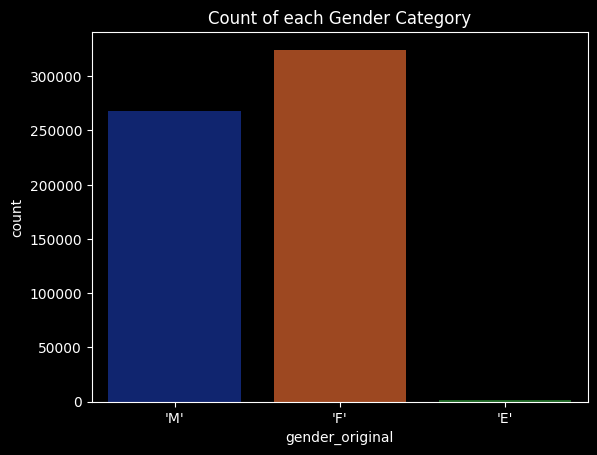

In [14]:
#plot count of each gender
sns.countplot(data=df, x='gender_original', hue='gender_original', palette='dark', legend=False);
plt.title('Count of each Gender Category')
plt.show()

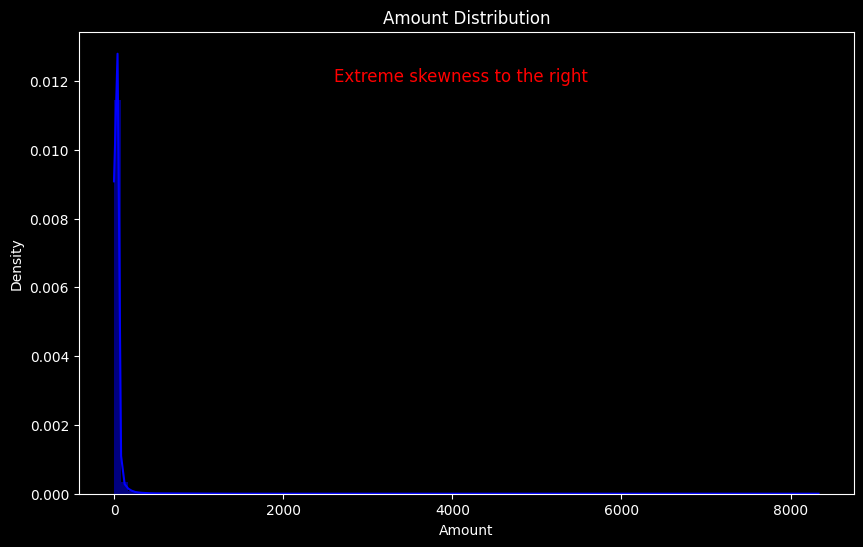

In [15]:
# plot the amount distribution
plt.figure(figsize=(10, 6))
sns.histplot(x=df['amount'], kde=True, color='blue', bins=100, stat='density', linewidth=0, alpha=0.5)
plt.title('Amount Distribution')
plt.xlabel('Amount')
plt.text(x=2600, y=0.012, s='Extreme skewness to the right', fontsize=12, color='red')
plt.show()

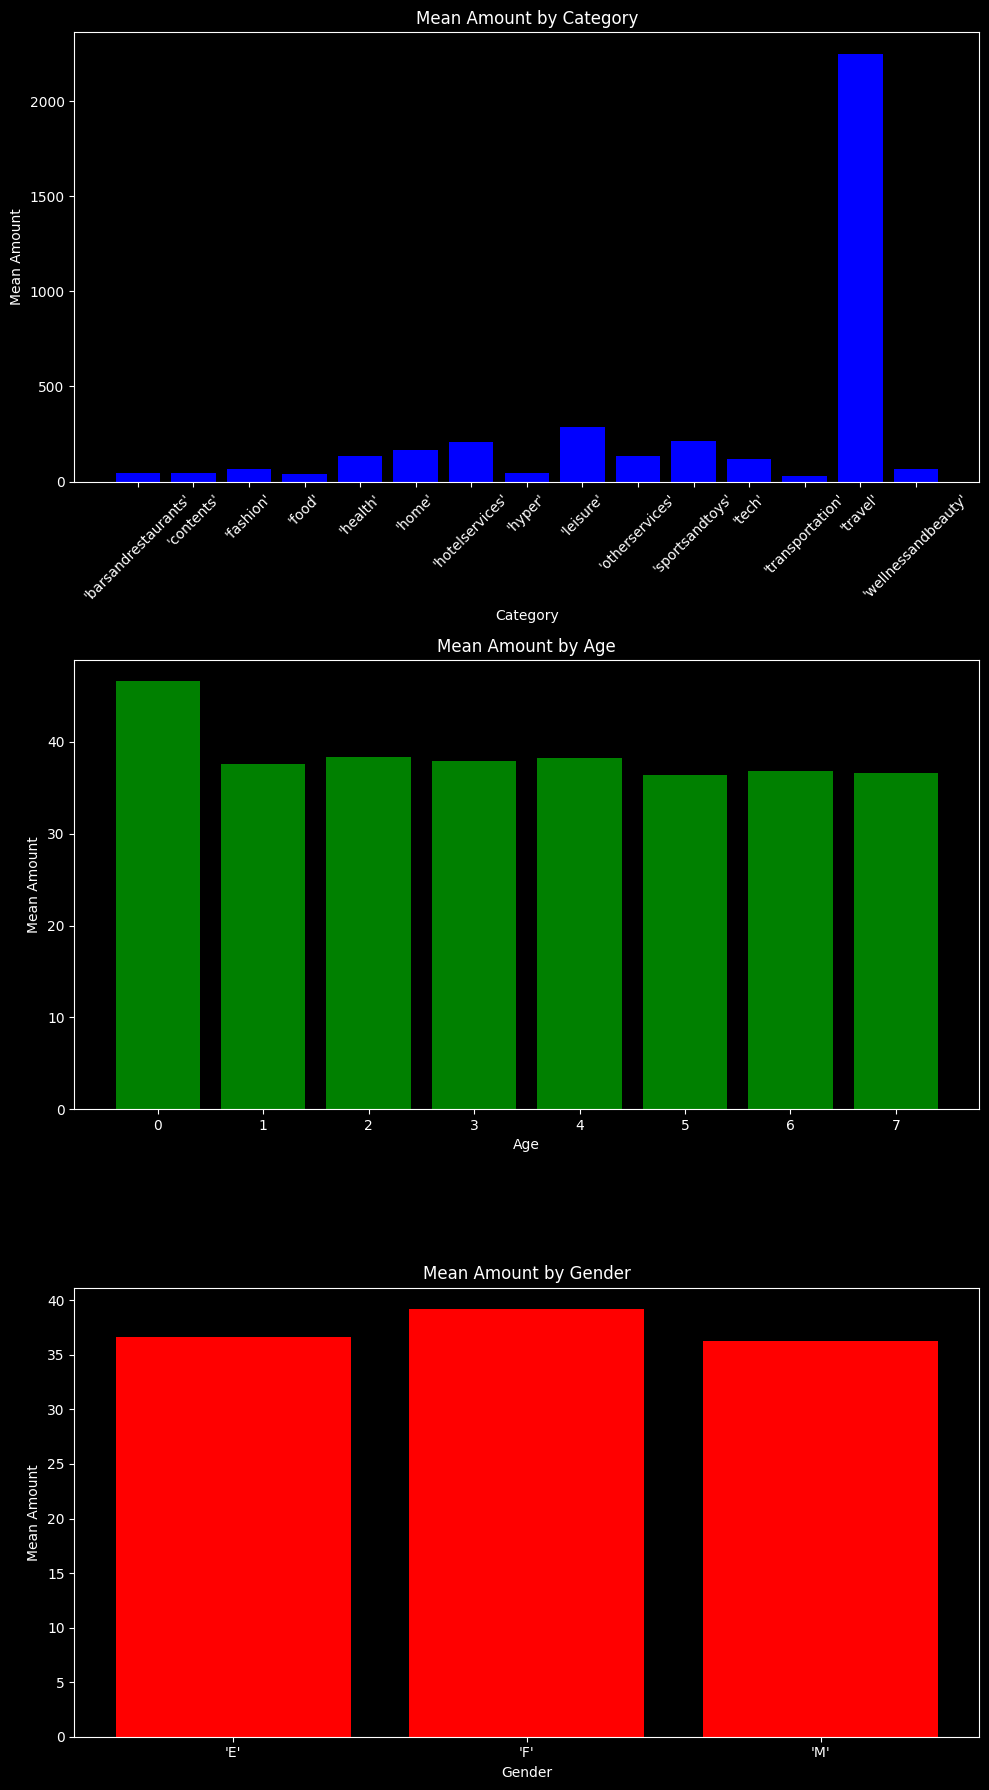

In [16]:
plt.figure(figsize=(10, 18))
plt.subplot(3, 1, 1)
plt.bar(df.groupby('category_original')['amount'].describe().index, df.groupby('category_original')['amount'].describe()['mean'], color='blue')
plt.title('Mean Amount by Category')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Mean Amount') 
plt.subplot(3, 1, 2)
plt.bar(df.groupby('age')['amount'].describe().index, df.groupby('age')['amount'].describe()['mean'], color='green')
plt.title('Mean Amount by Age')
plt.xlabel('Age')
plt.ylabel('Mean Amount')
plt.subplot(3, 1, 3)
plt.bar(df.groupby('gender_original')['amount'].describe().index, df.groupby('gender_original')['amount'].describe()['mean'], color='red')
plt.title('Mean Amount by Gender')
plt.xlabel('Gender')
plt.ylabel('Mean Amount')
plt.tight_layout()
plt.show()


#### 3.2.1 Fraud Plots

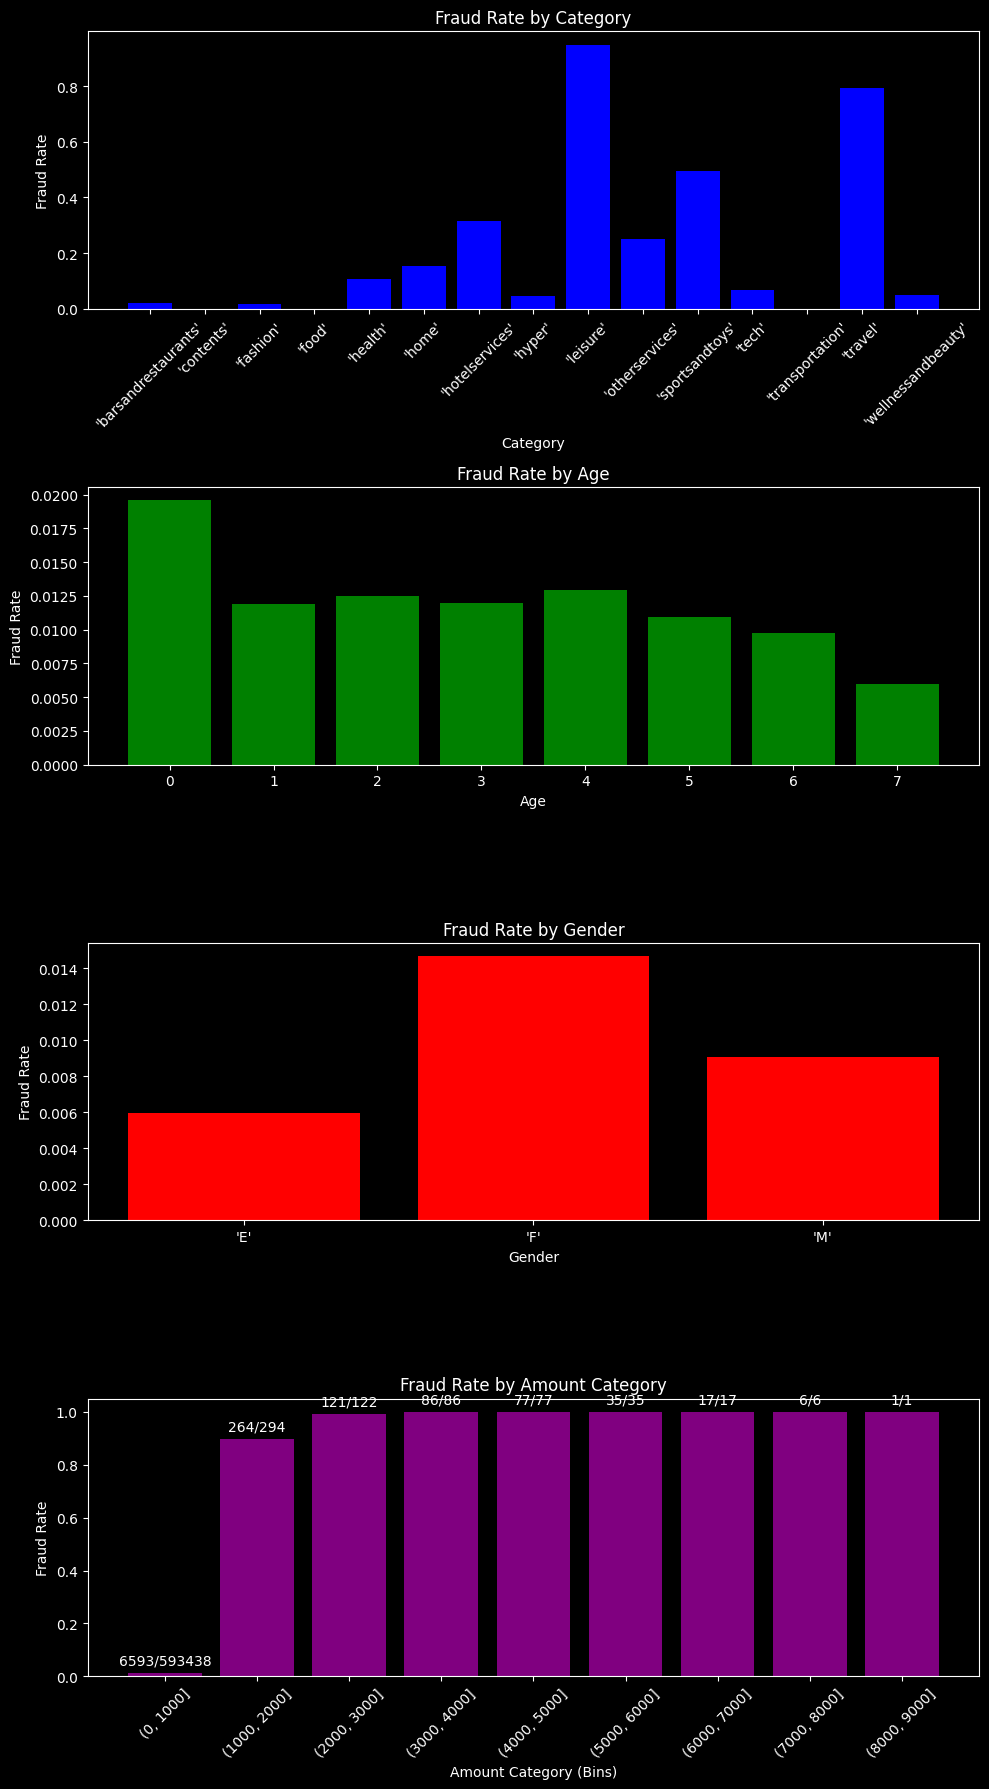

In [17]:
# plot the frauds distribution in corelation with the amount / gender / age / category
plt.figure(figsize=(10, 18))
plt.subplot(4, 1, 1)
plt.bar(df.groupby('category_original')['fraud'].describe().index, df.groupby('category_original')['fraud'].describe()['mean'], color='blue')
plt.title('Fraud Rate by Category')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.ylabel('Fraud Rate')
plt.subplot(4, 1, 2)
plt.bar(df.groupby('age')['fraud'].describe().index, df.groupby('age')['fraud'].describe()['mean'], color='green')
plt.title('Fraud Rate by Age')
plt.xlabel('Age')
plt.ylabel('Fraud Rate')
plt.subplot(4, 1, 3)
plt.bar(df.groupby('gender_original')['fraud'].describe().index, df.groupby('gender_original')['fraud'].describe()['mean'], color='red')
plt.title('Fraud Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Fraud Rate')
plt.subplot(4, 1, 4)

# plot the fraud rate by amount, using bins of 1000

amount_bins = pd.cut(df['amount'], bins=range(0, int(df['amount'].max()) + 1000, 1000))
fraud_rate_by_amount = df.groupby(amount_bins,observed=False)['fraud'].mean()
fraud_counts_by_amount = df.groupby(amount_bins, observed=False)['fraud'].sum()
total_counts_by_amount = df.groupby(amount_bins, observed=False)['fraud'].count()

bars = plt.bar(fraud_rate_by_amount.index.astype(str), fraud_rate_by_amount.values, color='purple')

# Annotate each bar with the count of frauds and total inputs
for bar, bin_label in zip(bars, fraud_rate_by_amount.index):
    height = bar.get_height()
    fraud_count = fraud_counts_by_amount[bin_label]
    total_count = total_counts_by_amount[bin_label]
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02,
             f"{fraud_count}/{total_count}",
             ha='center', va='bottom', fontsize=10)
plt.bar(fraud_rate_by_amount.index.astype(str), fraud_rate_by_amount.values, color='purple')
plt.xticks(rotation=45)
plt.title('Fraud Rate by Amount Category')
plt.xlabel('Amount Category (Bins)')
plt.ylabel('Fraud Rate')
plt.tight_layout()
plt.show()

# 4. Classification

In [48]:
# Define the features and target variable
X = df.drop(columns=['fraud','gender_original','category_original'])
y = df['fraud']

In [49]:
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Apply SMOTE to the training data
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

In [50]:
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [57]:
def showResults(model,X_test,y_test, y_pred=None):
    if y_pred is None:
        y_pred = model.predict(X_test)
    #show results on the test set
    confMat = confusion_matrix(y_test, y_pred)
    confusion_matrix_display = ConfusionMatrixDisplay(confMat, display_labels=['Not Fraud', 'Fraud'])
    confusion_matrix_display.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    #print classification report
    print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))

## 4.1. KNN

### 4.1.1 Initial attempt

In [17]:
def findBestKBasedOnRecall(resultsFile, X_train, y_train, X_valid, y_valid, w='uniform'):
    """
    Function to find the best K value for KNN classifier based on recall
    (we evaluate the model using recall, because we want to minimize the false negatives
    i.e. we want to catch as many frauds as possible)
    if the results file exists, it will load the results from the file
    if not, it will compute the results and save them to the file
    """

    recall_dict = {}
    recall_df = None
    # Check if the file exists
    if os.path.exists(resultsFile):
        # Load recall dict from file
        recall_dict = pd.read_csv(resultsFile)
        recall_dict = recall_dict.set_index('k').to_dict()['recall']
        recall_dict = {int(k): v for k, v in recall_dict.items()}
        recall_df = pd.DataFrame(recall_dict.values(), columns=['recall'], index=recall_dict.keys())
    else:
        # Loop over different values of k
        for k in range(2, 21):
            start_time = time.time()
            # Setup a k-NN Classifier with k neighbors: knn
            knn_clf = KNeighborsClassifier(n_neighbors=k, weights=w)

            # Fit the classifier to the training data
            knn_clf.fit(X_train, y_train)
            
            #Compute recall on the test set
            recall_dict[k] = recall_score(y_valid, knn_clf.predict(X_valid))
            elapsed_time = time.time() - start_time
            print(f"Recall for k={k}: {recall_dict[k]} Elapsed time: {elapsed_time:.4f} seconds")
            
        #write the recall dict to file
        recall_df = pd.DataFrame(recall_dict.values(), columns=['recall'], index=recall_dict.keys())
        recall_df.to_csv(resultsFile, index_label='k')

    recall_df = recall_df.sort_values(by='recall', ascending=False)

    #plot the recall values
    plt.figure(figsize=(10, 6))
    plt.scatter(recall_df.index, recall_df['recall'], marker='o', linestyle='-', color='red')
    plt.title('Recall vs. K Value')
    plt.xlabel('K Value')
    plt.ylabel('Recall')
    plt.xticks(recall_df.index)
    plt.grid()
    plt.show()
    return recall_df

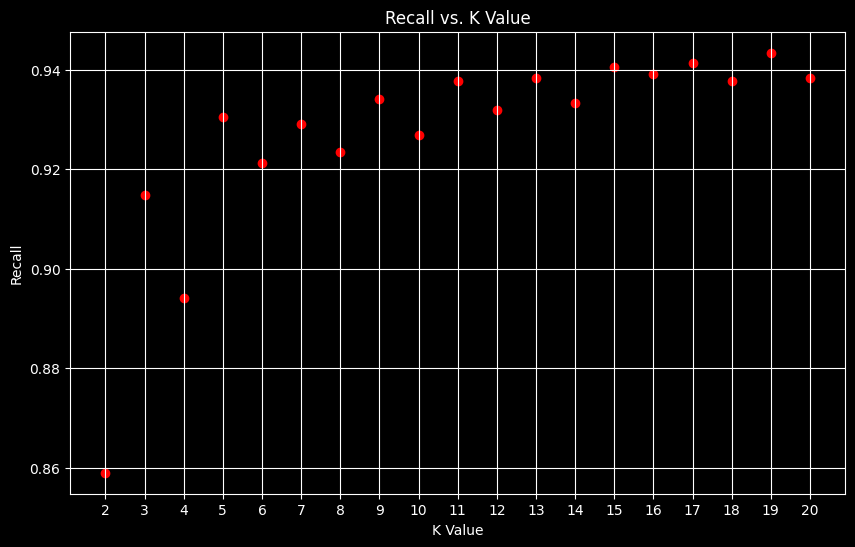

,recall
19,0.943450
17,0.941303
15,0.940587
16,0.939155
13,0.938440
20,0.938440
11,0.937724
18,0.937724
9,0.934145
14,0.933429


In [18]:
recall_df = findBestKBasedOnRecall('results/recall_dict_basic.csv', X_train, y_train, X_valid, y_valid)
recall_df

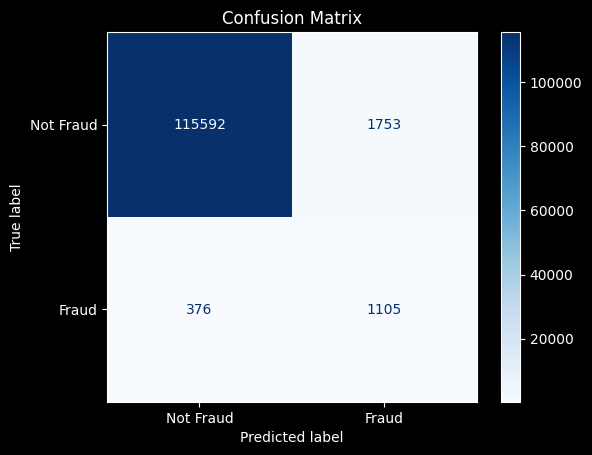

              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      0.99    117345
       Fraud       0.39      0.75      0.51      1481

    accuracy                           0.98    118826
   macro avg       0.69      0.87      0.75    118826
weighted avg       0.99      0.98      0.98    118826



In [19]:
# get the best k value
k = recall_df.index[0]  # Number of neighbours

# name that we gave to the "algo" instance
neighbours_clf = KNeighborsClassifier(n_neighbors=k)
# Fit the model on the training set
neighbours_clf.fit(X_train, y_train)

showResults(neighbours_clf, X_test, y_test)

376 missed frauds and 1753 falsely classified as fraud

### 4.1.2. With PCA

KNN is strongly affected by curse of dimensionality, so we try reducing dimension

In [20]:
# retry with pca
# Create a PCA instance: pca
pca = PCA(n_components=3)
# Fit the PCA instance to the training data
pca.fit(X_train)
# Transform the training data: X_train_pca
X_train_pca = pca.transform(X_train)
# Transform the validation data: X_valid_pca
X_valid_pca = pca.transform(X_valid)
# Transform the test data: X_test_pca
X_test_pca = pca.transform(X_test)

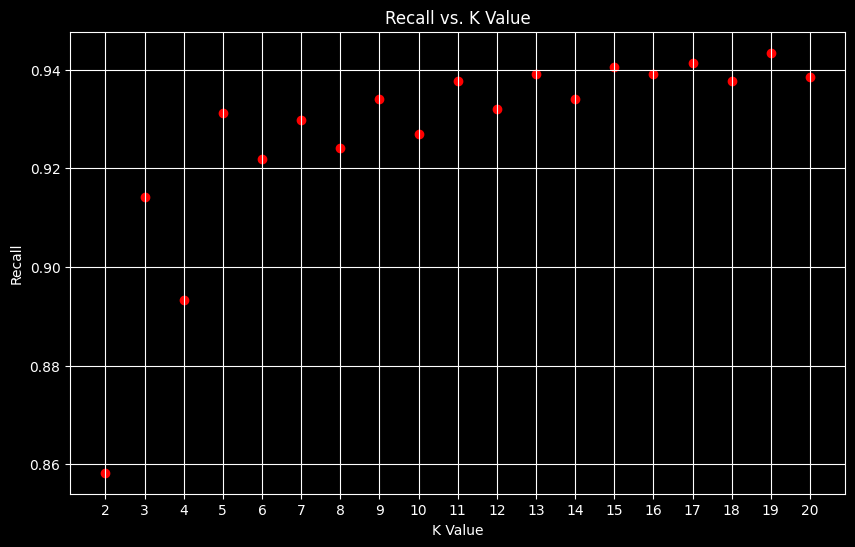

In [21]:
recall_df = findBestKBasedOnRecall('results/recall_dict_pca.csv', X_train_pca, y_train, X_valid_pca, y_valid)

In [22]:
recall_df

,recall
19,0.943450
17,0.941303
15,0.940587
16,0.939155
13,0.939155
20,0.938440
11,0.937724
18,0.937724
9,0.934145
14,0.934145


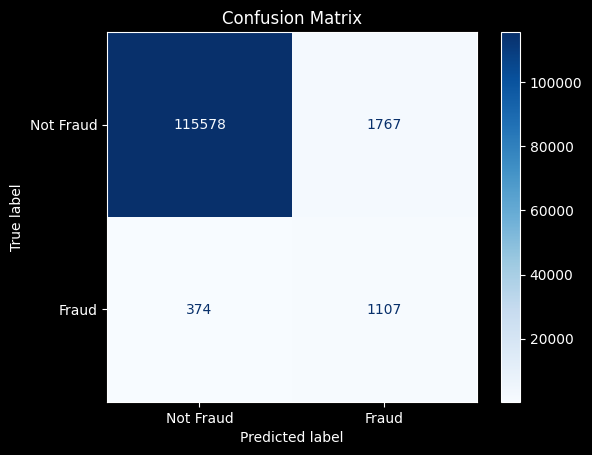

              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99    117345
       Fraud       0.39      0.75      0.51      1481

    accuracy                           0.98    118826
   macro avg       0.69      0.87      0.75    118826
weighted avg       0.99      0.98      0.98    118826



In [23]:
# get the best k value
k = recall_df.index[0]  # Number of neighbours

# name that we gave to the "algo" instance
neighbours_clf_pca = KNeighborsClassifier(n_neighbors=k)
# Fit the model on the training set
neighbours_clf_pca.fit(X_train_pca, y_train)

showResults(neighbours_clf_pca, X_test_pca, y_test)

almost the same result as with no pca, so we didnt achieve anything accept for speed

### 4.1.3. With Pca & weights based on distance

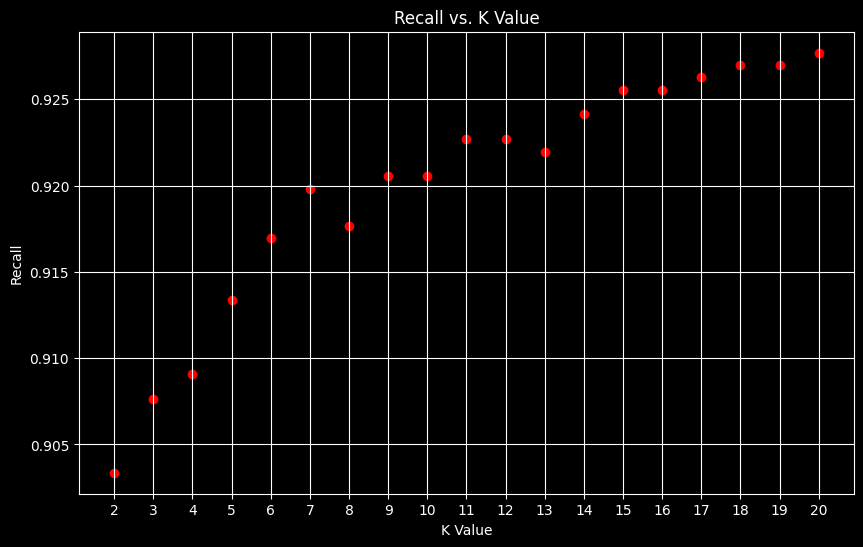

,recall
20,0.927702
18,0.926986
19,0.926986
17,0.926271
16,0.925555
15,0.925555
14,0.924123
12,0.922691
11,0.922691
13,0.921976


In [24]:
recall_df = findBestKBasedOnRecall('results/recall_dict_pca_dist.csv', X_train_pca, y_train, X_valid_pca, y_valid, w='distance')
recall_df

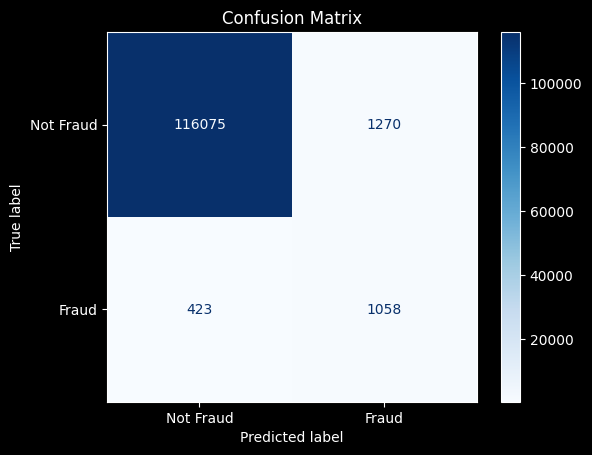

              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      0.99    117345
       Fraud       0.45      0.71      0.56      1481

    accuracy                           0.99    118826
   macro avg       0.73      0.85      0.77    118826
weighted avg       0.99      0.99      0.99    118826



In [25]:
k = recall_df.index[0]  # Number of neighbours

# name that we gave to the "algo" instance
neighbours_clf_pca_weighted = KNeighborsClassifier(n_neighbors=k, weights='distance')
# Fit the model on the training set
neighbours_clf_pca_weighted.fit(X_train_pca, y_train)

showResults(neighbours_clf_pca_weighted, X_test_pca, y_test)

Worse than before

## 4.2. Logistic Regression

In [26]:
pipeline_instance = Pipeline([('scaler', MaxAbsScaler()), ('classifier', LogisticRegression())])

param_grid = [{
    'classifier': [LogisticRegression(max_iter=1000, class_weight='balanced')],
    #using balanced weights is the best choice, since the dataset classes are extremely inbalanced 
    'classifier__penalty': ['l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__solver': ['lbfgs', 'saga']
}]


In [27]:
model = None
if os.path.exists('results/logistic_regression_model.pkl'):
    #load the model
    model = joblib.load('results/logistic_regression_model.pkl')
else:
    grid = GridSearchCV(
        estimator=pipeline_instance,
        param_grid=param_grid,
        scoring=make_scorer(recall_score), #score based on recall
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X, y)
    #save the model
    joblib.dump(grid.best_estimator_, 'results/logistic_regression_model.pkl')
    model = grid.best_estimator_


In [28]:
model

Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    max_iter=1000))])

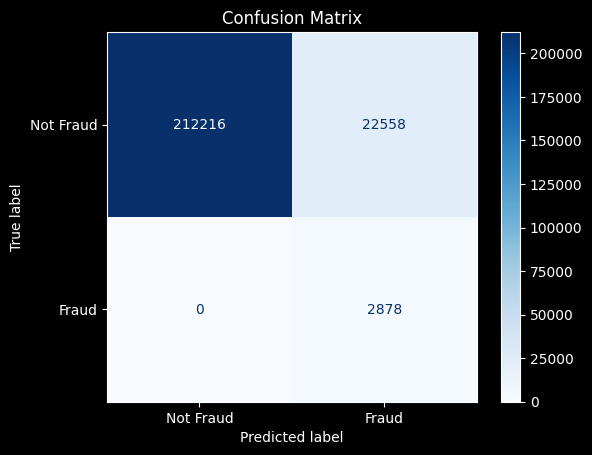

              precision    recall  f1-score   support

   Not Fraud       1.00      0.90      0.95    234774
       Fraud       0.11      1.00      0.20      2878

    accuracy                           0.91    237652
   macro avg       0.56      0.95      0.58    237652
weighted avg       0.99      0.91      0.94    237652



In [ ]:
# create a new split, to evaluate the best estimator 
# (we don't use the split used in knn because in the best estimator we have included scaling and weighted LR model
# and initial KNN split is scaled and SMOTE is applied on them)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.4, random_state=42)
model.fit(X_train_lr, y_train_lr)
showResults(model, X_test_lr, y_test_lr)

Great recall but a lot of data falsly classify as fraud. Perhaps we should try and tangle with the decision thresholds

## 4.4. svm

This **does not** converge

In [31]:
# pipeline_instance = Pipeline([('scaler', MaxAbsScaler()), ('classifier', SVC())])

# param_grid = [{
#     'classifier': [SVC(class_weight='balanced')],
#     'classifier__C': [0.001, 0.01, 0.1],
#     'classifier__kernel': ['linear', 'rbf', 'poly'],
#     'classifier__degree': [2, 3, 4]
# }]
# model = None
# if os.path.exists('results/svc_model.pkl'):
#     #load the model
#     model = joblib.load('results/svc_model.pkl')
# else:
#     grid = GridSearchCV(
#         estimator=pipeline_instance,
#         param_grid=param_grid,
#         scoring=make_scorer(recall_score), #score based on recall
#         cv=5,
#         n_jobs=-1,
#         verbose=1
#     )

#     grid.fit(X, y)
#     #save the model
#     joblib.dump(grid.best_estimator_, 'results/svc_model.pkl')
#     model = grid.best_estimator_
# model


In [ ]:
# # create a new split, to evaluate the best estimator 
# # (we don't use the split used in knn because in the best estimator we have included scaling and weighted LR model
# # and initial KNN split is scaled and SMOTE is applied on them)
# X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size=0.4, random_state=42)
# model.fit(X_train_svm, y_train_svm)
# y_pred = model.predict(X_test_svm)

# showResults(model, X_test_svm, y_test_svm)

## 4.5 random forest

In [34]:
# GridSearchCV for Random Forest Classifier
pipeline_instance = Pipeline([('scaler', MaxAbsScaler()), ('classifier', RandomForestClassifier())])
param_grid = [{
    'classifier': [RandomForestClassifier(class_weight='balanced')],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}]
model = None
if os.path.exists('results/random_forest_model.pkl'):
    #load the model
    model = joblib.load('results/random_forest_model.pkl')
else:
    grid = GridSearchCV(
        estimator=pipeline_instance,
        param_grid=param_grid,
        scoring=make_scorer(recall_score), #score based on recall
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X, y)
    #save the model
    joblib.dump(grid.best_estimator_, 'results/random_forest_model.pkl')
    model = grid.best_estimator_
model

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=4, min_samples_split=5,
                                        n_estimators=50))])

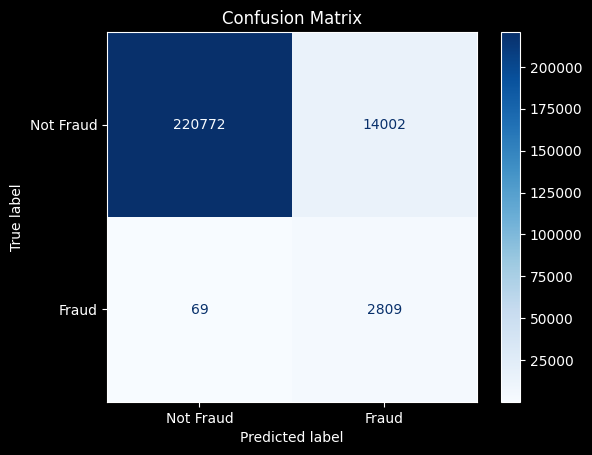

              precision    recall  f1-score   support

   Not Fraud       1.00      0.94      0.97    234774
       Fraud       0.17      0.98      0.29      2878

    accuracy                           0.94    237652
   macro avg       0.58      0.96      0.63    237652
weighted avg       0.99      0.94      0.96    237652



In [36]:
# use the same split as in the logistic regression model, since it is scaled and SMOTE is applied on them  
model.fit(X_train_lr, y_train_lr)
showResults(model, X_test_lr, y_test_lr)

Very good recall, and better accuracy than logistic regression

## 4.6. xgboost

In [45]:
# apply xgboost
pipeline_instance = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('classifier', XGBClassifier(eval_metric='logloss', scale_pos_weight=1, tree_method='hist'))
])

param_grid = {
    'classifier__n_estimators': [100, 300],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__scale_pos_weight': [1, 10], # balancing
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [1.0, 0.8, 0.6]
}
model = None
if os.path.exists('results/xgboost_model.pkl'):
    #load the model
    model = joblib.load('results/xgboost_model.pkl')
else:
    grid = GridSearchCV(
        estimator=pipeline_instance,
        param_grid=param_grid,
        scoring=make_scorer(recall_score), #score based on recall
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X, y)
    #save the model
    joblib.dump(grid.best_estimator_, 'results/xgboost_model.pkl')
    model = grid.best_estimator_
model

Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

c:\Developer\MSC\semester B\Python\venvs\.venv-assignment\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:14:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


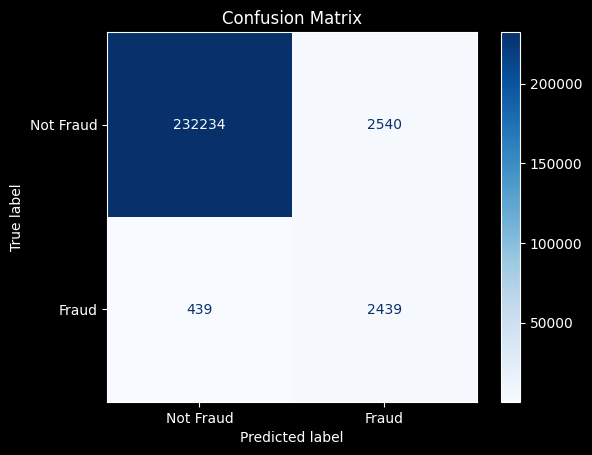

              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      0.99    234774
       Fraud       0.49      0.85      0.62      2878

    accuracy                           0.99    237652
   macro avg       0.74      0.92      0.81    237652
weighted avg       0.99      0.99      0.99    237652



In [46]:
# use the same split as in the logistic regression model, since it is scaled and SMOTE is applied on them
model.fit(X_train_lr, y_train_lr)
showResults(model, X_test_lr, y_test_lr)

recall score is not that good, but precision is significanlty better.
However 85% recall 439/2878 frauds passed the detection, which is very bad if we think in scale ...

## 4.7 Naive Bayes

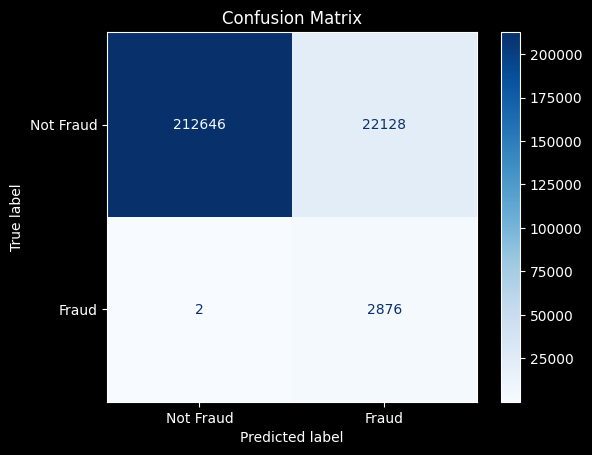

              precision    recall  f1-score   support

   Not Fraud       1.00      0.91      0.95    234774
       Fraud       0.12      1.00      0.21      2878

    accuracy                           0.91    237652
   macro avg       0.56      0.95      0.58    237652
weighted avg       0.99      0.91      0.94    237652



In [48]:
#apply Gaussian Naive Bayes
model = GaussianNB()
# Fit the model on the training set
model.fit(X_train_lr, y_train_lr)
showResults(model, X_test_lr, y_test_lr)

Great recall but very bad precision. Similar scores to lr, with the big difference that this predictor cant be fine tuned. 

## 4.8. Simple Neural Networks

Lets try a Multi layer perceptron from sklearn for starters

In [ ]:
# Step 1: Build the pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('mlp', MLPClassifier(random_state=42, early_stopping=True, max_iter=200))
])

# Step 2: Define the parameter grid
param_grid = {
    'mlp__hidden_layer_sizes': [(32,), (64,), (32, 32)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__solver': ['adam', 'sgd'],
}

# Step 3: Grid search with recall as scoring
grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring=make_scorer(recall_score),
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Step 4: Fit if best model is not saved
if os.path.exists('results/mlp_model.pkl'):
    # Load the model
    model = joblib.load('results/mlp_model.pkl')
else:
    grid.fit(X, y)
    # Save the best model
    joblib.dump(grid.best_estimator_, 'results/mlp_model.pkl')

    # Step 5: Check best results
    print("Best parameters:", grid.best_params_)
    print("Best recall score:", grid.best_score_)
    model = grid.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (32, 32), 'mlp__solver': 'sgd'}
Best recall score: 0.9808333333333333


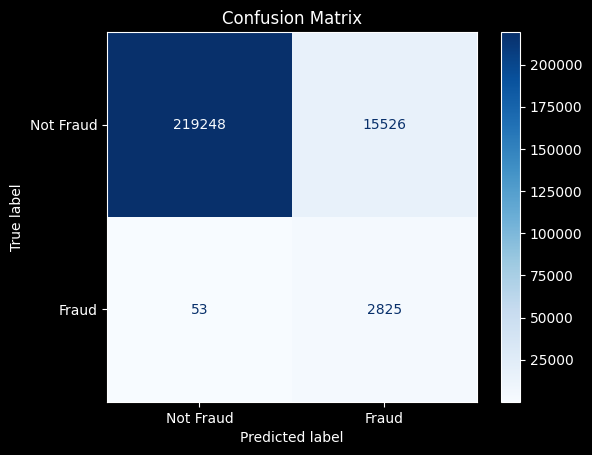

              precision    recall  f1-score   support

   Not Fraud       1.00      0.93      0.97    234774
       Fraud       0.15      0.98      0.27      2878

    accuracy                           0.93    237652
   macro avg       0.58      0.96      0.62    237652
weighted avg       0.99      0.93      0.96    237652



In [39]:
model.fit(X_train_lr, y_train_lr)
showResults(grid.best_estimator_, X_test_lr, y_test_lr)

Best Model so far, very good weighted averages, only 53/2878 fraud samples missed

In [ ]:
# ---- 1. Convert Data to tensors ----
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).unsqueeze(1)

# ---- 2. Neural Net ----
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, activation):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.act = activation
        self.fc2 = nn.Linear(hidden_size, 1)
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.out(self.fc2(x))
        return x

# ---- 3. Grid Search Params ----
param_grid = {
    'hidden_size': [32, 64],
    'lr': [0.001, 0.0005],
    'activation': [nn.ReLU(), nn.Tanh()],
    'epochs': [100],  # Let it run long; early stopping will kick in
    'patience': [10]
}

In [101]:
from sklearn.utils.class_weight import compute_class_weight

#if model is already saved, load it
if os.path.exists('results/best_nn_model.pth'):
    # Load the model
    model = SimpleNN(X_train_tensor.shape[1], 64, nn.ReLU())
    model.load_state_dict(torch.load('results/best_nn_model.pth'))
    model.eval()
    print("Model loaded successfully.")
else:
    # Compute weights 
    y_array = y_train_tensor.numpy().astype(int).flatten()

    # Compute class weights properly
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_array), 
        y=y_array
    )
    weight_tensor = torch.tensor([class_weights[1]], dtype=torch.float32)

    # --- Loop Setup ---
    best_score = float('inf')  # minimize BCE loss
    best_params = {}
    best_y_pred = None

    # Grid Search Loop
    for hidden_size, lr, activation, epochs, patience in product(*param_grid.values()):
        model = SimpleNN(X_train_tensor.shape[1], hidden_size, activation)
        criterion = nn.BCELoss(weight=weight_tensor)  # weighted BCE loss
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

        best_val_loss = float('inf')
        early_stop_counter = 0

        for epoch in range(epochs):
            # --- Train ---
            model.train()
            optimizer.zero_grad()
            output = model(X_train_tensor)
            loss = criterion(output, y_train_tensor)
            loss.backward()
            optimizer.step()

            # --- Validation ---
            model.eval()
            with torch.no_grad():
                val_output = model(X_valid_tensor)
                val_loss = criterion(val_output, y_valid_tensor)
                val_loss_val = val_loss.item()

            scheduler.step(val_loss_val)

            # --- Early Stopping Logic ---
            if val_loss_val < best_val_loss:
                best_val_loss = val_loss_val
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print(f"Early stopping at epoch {epoch} (val BCE: {val_loss_val:.4f})")
                    break

        # --- Track Best Overall ---
        if best_val_loss < best_score:
            best_score = best_val_loss
            best_params = {
                'hidden_size': hidden_size,
                'lr': lr,
                'activation': activation.__class__.__name__,
                'epochs_trained': epoch + 1,
                'patience': patience
            }
            # Save model
            torch.save(model.state_dict(), 'results/best_nn_model.pth')
            best_y_pred = (val_output > 0.5).int().cpu().numpy()

    print(f"Best BCE Loss: {best_score:.4f}")
    print(f"Best Hyperparameters: {best_params}")

Early stopping at epoch 10 (val BCE: 0.6444)
Best BCE Loss: 0.2770
Best Hyperparameters: {'hidden_size': 64, 'lr': 0.001, 'activation': 'Tanh', 'epochs_trained': 100, 'patience': 10}


In [104]:
scaler.fit(X_train_lr)
X_test_nn=scaler.transform(X_test_lr)

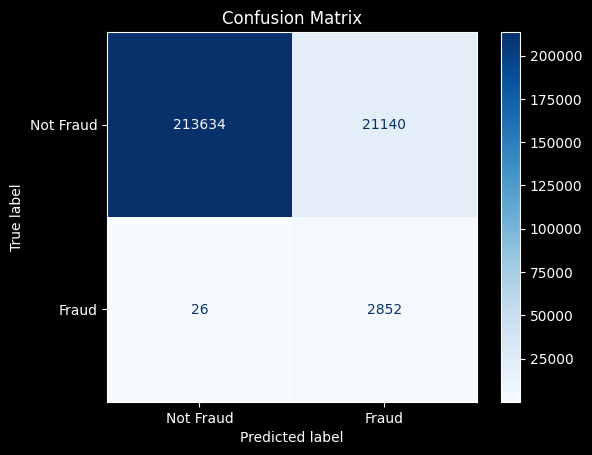

              precision    recall  f1-score   support

   Not Fraud       1.00      0.91      0.95    234774
       Fraud       0.12      0.99      0.21      2878

    accuracy                           0.91    237652
   macro avg       0.56      0.95      0.58    237652
weighted avg       0.99      0.91      0.94    237652



In [105]:
# load the best model
best_model = SimpleNN(X_train_tensor.shape[1], best_params['hidden_size'], getattr(nn, best_params['activation'])())
best_model.load_state_dict(torch.load('results/best_nn_model.pth'))
# Evaluate the best model on the test set
best_model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_lr.values, dtype=torch.float32).unsqueeze(1)
    test_preds = best_model(X_test_tensor).round()
    showResults(best_model, X_test_tensor.numpy(), y_test_tensor.numpy(), test_preds.numpy())

Also quite good scores, but precision is pretty lower

# 5. Final thoughts & next steps

Most classifiers achieve a very good recall score. (Logistic Regression and naive bayes achieve 100%).

Recall is a very important metric in fraud detection, since we need to minimize the fraudulent transactions that don't get detected as fraud. However we understand that focusing only on recall to evaluate our models is not correct either, since if we classify all the samples as fraud, we achieve 100% recall. 

The precision  is pretty low in all the models, and a lot of non-fraud transactions are classified as fraud.
So as a next step for our project we should focus on achieving better precision, without lowering the recall score. 
We could try more complex models, or some feature engineering. Also we could explore the dataset and see the data in which our classifiers struggle the most.